# Imports and Loading Evaluator

In [1]:
import matplotlib.pyplot as plt 
plt.style.use('fivethirtyeight')

import wasmshield.evaluator.transforms
import wasmshield.utils
import wasmshield.preprocessing
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
device = 'mps'

transforms_evaluator = wasmshield.evaluator.transforms.TransformsEvaluator(
    device,
    n_train=2000,
    n_test=500,
)


/opt/homebrew/Caskroom/miniforge/base/envs/datascience/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2024-05-11 19:33:37.640291: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-11 19:33:37.640664: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
100%|██████████| 3715/3715 [00:00<00:00, 17705.57it/s]


Preloaded pairs


# Loading ResBin Models

In [2]:
import wasmshield.training.trainer
import wasmshield.models.resbin
from wasmshield.models.resbin import *

model_name_18 = 'Emprique60_2_ResBin18_b64_i64_pil_v128_rmax_t015'
trainable_model_18 = wasmshield.training.trainer.TrainableModel(model=None, name=model_name_18, device=device)
resbin_18_sa = wasmshield.models.resbin.ResBinHandler(
    trainable_model_18.model.backbone
)

model_name_8 = 'Emprique60_2_ResBin8_b64_i64_pil_v128_rmax_t015'
trainable_model_8 = wasmshield.training.trainer.TrainableModel(model=None, name=model_name_8, device=device)
resbin_8_sa = wasmshield.models.resbin.ResBinHandler(
    trainable_model_8.model.backbone
)

model_name_18_woSA= 'Emprique60_2_ResBin18_woSA_b64_i64_pil_v128_rmax_t015'
trainable_model_18_woSA = wasmshield.training.trainer.TrainableModel(model=None, name=model_name_18_woSA, device=device)
resbin_18 = wasmshield.models.resbin.ResBinHandler(
    trainable_model_18_woSA.model.backbone
)

model_name_8_woSA = 'Emprique60_2_ResBin8_woSA_b64_i64_pil_v128_rmax_t015'
trainable_model_8_woSA = wasmshield.training.trainer.TrainableModel(
    model=None, 
    name=model_name_8_woSA, 
    device=device
)
resbin_8 = wasmshield.models.resbin.ResBinHandler(
    trainable_model_8_woSA.model.backbone
)


Attempting to load model_name=Emprique60_2_ResBin18_b64_i64_pil_v128_rmax_t015
Attempting to load model_name=Emprique60_2_ResBin8_b64_i64_pil_v128_rmax_t015
Attempting to load model_name=Emprique60_2_ResBin18_woSA_b64_i64_pil_v128_rmax_t015
Attempting to load model_name=Emprique60_2_ResBin8_woSA_b64_i64_pil_v128_rmax_t015


# Preparing data pairs

In [3]:

X_train_8_sa, y_train_8_sa, X_test_8_sa, y_test_8_sa, X_test_new_8_sa, y_test_new_8_sa = transforms_evaluator.get_X_y(
    resbin_8_sa,
)

X_train_18_sa, y_train_18_sa, X_test_18_sa, y_test_18_sa, X_test_new_18_sa, y_test_new_18_sa = transforms_evaluator.get_X_y(
    resbin_18_sa,
)

X_train_8, y_train_8, X_test_8, y_test_8, X_test_new_8, y_test_new_8 = transforms_evaluator.get_X_y(
    resbin_8,
)

X_train_18, y_train_18, X_test_18, y_test_18, X_test_new_18, y_test_new_18 = transforms_evaluator.get_X_y(
    resbin_18,
)      


100%|██████████| 7/7 [00:01<00:00,  4.99it/s]


# Loading JabberWock

In [4]:
import wasmshield.approaches.jabberwock
from gensim.models import Doc2Vec

doc2vec = Doc2Vec.load('models/doc2vec_pairs.model')

jabberwock_handler = wasmshield.approaches.jabberwock.JabberWockHandler(
    doc2vec, 
    save_vectors_in="/Volumes/Walid-SSD/ESI/PFE/DATASETS/jabberwock_pairs_vectors_128/",
)

X_train_jw, y_train_jw, X_test_jw, y_test_jw, X_test_new_jw, y_test_new_jw = transforms_evaluator.get_X_y(
    jabberwock_handler,
)


100%|██████████| 7/7 [00:00<00:00, 18.88it/s]


# Evaluation

In [5]:
import pandas as pd
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report

palette=sns.color_palette("tab10", n_colors=20)
sns.set_palette(palette=palette, n_colors=20)


In [6]:
models = [
    ('JabberWock', X_train_jw, y_train_jw, X_test_jw, y_test_jw, X_test_new_jw, y_test_new_jw),
    ('ResBin8', X_train_8, y_train_8, X_test_8, y_test_8, X_test_new_8, y_test_new_8),
    ('ResBin18', X_train_18, y_train_18, X_test_18, y_test_18, X_test_new_18, y_test_new_18),
    ('ResBin8-SA', X_train_8_sa, y_train_8_sa, X_test_8_sa, y_test_8_sa, X_test_new_8_sa, y_test_new_8_sa),
    ('ResBin18-SA', X_train_18_sa, y_train_18_sa, X_test_18_sa, y_test_18_sa, X_test_new_18_sa, y_test_new_18_sa),
]


In [7]:
import tqdm
import xgboost, catboost, time

X_y_augmenter = lambda X,y : (np.concatenate([X, np.concatenate([X[:,X.shape[1]//2:], X[:,:X.shape[1]//2]], axis=1) ]), np.concatenate((y,y)))

def train_sklearn_model(sklearn_model, X_train, y_train):
    X_train, y_train = X_y_augmenter(X_train, y_train)
    p = np.arange(0, len(X_train))
    np.random.shuffle(p)
    sklearn_model.fit(X_train[p], y_train[p],)
    return sklearn_model

new_models = []

for (
    model_name, 
    x_train, y_train, 
    x_test, y_test, 
    x_test_new, y_test_new
) in tqdm.tqdm(models):
    
    start_train = time.perf_counter()
    sklearn_model = train_sklearn_model(
        catboost.CatBoostClassifier(
            verbose=False, 
            n_estimators=2000, 
            eval_fraction=0.2, eval_metric='TotalF1',
        ),
        x_train,
        y_train
    )
    train_time = time.perf_counter() - start_train
    new_models.append(
        (model_name+'+CatBoost', sklearn_model, train_time, x_train, y_train,
        x_test, y_test, x_test_new, y_test_new, )
    )


100%|██████████| 5/5 [04:56<00:00, 59.30s/it]


In [8]:
obfuscation_types = [
    'obfuscation_InitOpaque',
    'obfuscation_AntiAliasAnalysis',
    'obfuscation_EncodeLiterals',
    'obfuscation_Flatten',
    'obfuscation_AntiTaintAnalysis',
    'obfuscation_Copy',
    'obfuscation_Virtualize',
]

llvm_obfuscation_types = [
    'obfuscation_constenc',
    'obfuscation_strcry',
    'obfuscation_subobf',
    'obfuscation_splitobf',
    'obfuscation_bcfobf',
    'obfuscation_cffobf',
    'obfuscation_funcwra',
]

mutated_types = [
    'mutated_Under_1KB',
    'mutated_1KB_and_100KB',
    'mutated_100KB_and_1MB',
    'mutated_1MB_and_100MB',
]

optim_types = [
    'O0_O1',
    'O0_O2',
    'O0_O3',
    'O0_Os',
    'O0_Oz',
    'O1_O2',
    'O1_O3',
    'O1_Os',
    'O1_Oz',
    'O2_O3',
    'O2_Os',
    'O2_Oz',
    'O3_Os',
    'O3_Oz',
    'Os_Oz',
]

all_groups = [
    None,
    {
        'obfuscation' : obfuscation_types,
        'optim_level' : optim_types,
        'mutation_sizes' : mutated_types,
        'llvm_obfuscation' : llvm_obfuscation_types,
    },
]

groups = all_groups[1]

In [9]:
import matplotlib.pyplot as plt 
plt.style.use('fivethirtyeight')


def eval_sklearn_model(sklearn_model, _X_test, _y_test, _X_test_new, _y_test_new, model_name, train_time, groups=None):
    from sklearn.metrics import classification_report, roc_curve, auc
    sklearn_model.verbose=0

    X_test = {**_X_test, **_X_test_new}
    y_test = {**_y_test, **_y_test_new}

    if groups is None:
        groups = {k:[k] for k in X_test.keys()}

    records = []
    for t, v in groups.items():
        _X_test_v = []
        _y_test_v = []

        for _v in v:
            _X_test_v.extend(X_test[_v])
            _y_test_v.extend(y_test[_v])

        y = _y_test_v
        pred = sklearn_model.predict(_X_test_v)
        fpr, tpr, thresholds = roc_curve(y, pred)
        roc_auc = auc(fpr, tpr)
        rep = classification_report(np.array(y), pred, output_dict=True)
        res = rep['weighted avg']
        res['accuracy'] = rep['accuracy']
        res['model_name'] = model_name
        res['transform_type'] = t
        res['roc_auc'] = roc_auc
        res['train_time'] = train_time
        records.append(res)

    return pd.DataFrame.from_records(records)

def drawer_grp(groups, models, figsize = (24,7,), fmt='%.3f', rotation=0, padding=2, cols=4, bbox_to_anchor=(0.5, 1.08), pad=0, hpad=0, wpad=0, show=True):

    df = pd.DataFrame()
    for model_name, sklearn_model, train_time, x_train, y_train, x_test, y_test, x_test_new, y_test_new in models:
        df8 = eval_sklearn_model(
            sklearn_model,
            x_test,
            y_test,
            x_test_new,
            y_test_new,
            model_name=model_name,
            groups=groups,
            train_time=train_time
        )
        df = pd.concat((df, df8))

    df['transform_type'] = [x.replace('obfuscation_','') for x in df['transform_type']]
    df['transform_type'] = [x.replace('mutated_','') for x in df['transform_type']]

    def drawer(y_name, ax, rotation=0):
        colors = ['#64B5F6', '#1976D2', '#66BB6A', '#2E7D32' ,'#ff6361','#ffa600','#003f5c', '#03a9f4', '#f44336', '#80CBC4',  'blue', 'lightblue', 'red']
        palette = sns.color_palette(palette=colors, n_colors=5)
        g = sns.barplot(df, x="transform_type", y=y_name, hue="model_name", palette=palette, ax=ax)
        g.legend(loc='upper center', bbox_to_anchor=bbox_to_anchor,
                fancybox=True, shadow=True, ncol=5)
        g.set(ylim=(0, 1.05))
        for i in g.containers:
            g.bar_label(i,fmt=fmt, rotation=0, padding=padding)
        ax.tick_params(axis='x', labelrotation=rotation)

    fig, axes = plt.subplots(nrows=1 if cols==4 else 4, ncols=4 if cols==4 else 1, figsize=figsize)
    fig.tight_layout(pad=pad, h_pad=hpad, w_pad=wpad)

    axes = axes.flatten()
    
    drawer("precision", axes[0], rotation=rotation)
    drawer("recall", axes[1], rotation=rotation)
    drawer("f1-score", axes[2], rotation=rotation)
    drawer("accuracy", axes[3], rotation=rotation)

    if show:
        fig.show()
    
    return df


In [ ]:
df_overall = drawer_grp(groups, new_models, figsize=(50,10), fmt='%.4f', cols=4, rotation=0)

In [ ]:
df_optim = drawer_grp({k:[k] for k in optim_types}, new_models, figsize=(60,30), fmt='%.4f', rotation=0, cols=1, bbox_to_anchor=(0.5, 1.08), hpad=4)

In [ ]:
df_tigress = drawer_grp({k:[k] for k in obfuscation_types}, new_models, figsize=(60,9), bbox_to_anchor=(0.5, 1.04), rotation=0)

In [ ]:
df_wasm_mutate = drawer_grp({k:[k] for k in mutated_types}, new_models, figsize=(50,8))

In [ ]:
df_llvm = drawer_grp({k:[k] for k in llvm_obfuscation_types}, new_models, figsize=(80,8), bbox_to_anchor=(0.5, 1.04), rotation=0, hpad=2)

# Results

In [37]:
def table_formatter(df, drop_technique=False, round_to=4, technique_rename:dict[str,str]={}):
    value_vars = [ 'f1-score', 'accuracy', ]
    id_vars = ['transform_type',]

    for v_var in value_vars:
        df[v_var] = [round(x,round_to) for x in df[v_var]]

    _df = df.copy()
    _df['Tool'] = [x.split('$')[1] for x in _df['transform_type']]
    _df['Technique'] = [x.split('$')[2] for x in _df['transform_type']]
    _df['Technique'] = [technique_rename.get(x,x).replace('_','\_') for x in _df['Technique']]
    if drop_technique is False:
        _df = _df.set_index(['Tool', 'Technique'])[value_vars+["model_name"]]
    else:
        _df = _df.set_index(['Tool',])[value_vars+["model_name"]]

    metric = value_vars

    model = _df['model_name'].unique()

    _df['model_name'] = [x.split('+')[0] for x in _df['model_name']]

    d = {}
    for _model in _df['model_name'].unique():
        _df_t = _df[_df['model_name'] == _model]
        d[_model] = _df_t.drop(columns=['model_name'])

    return pd.concat(d, axis=1), _df


\begin{table}
\caption{Similarity detection inference results.}
\label{tab:rq2_results}
\begin{tabular}{lrrrrrrrrrr}
\toprule
 & \multicolumn{2}{c}{JabberWock+CatBoost} & \multicolumn{2}{c}{ResBin8+CatBoost} & \multicolumn{2}{c}{ResBin18+CatBoost} & \multicolumn{2}{c}{ResBin8-SA+CatBoost} & \multicolumn{2}{c}{ResBin18-SA+CatBoost} \\
 & f1-score & accuracy & f1-score & accuracy & f1-score & accuracy & f1-score & accuracy & f1-score & accuracy \\
Tool &  &  &  &  &  &  &  &  &  &  \\
\midrule
Obfuscation(Tigress) & 0.8541 & 0.8541 & 0.9204 & 0.9204 & 0.9276 & 0.9276 & 0.9207 & 0.9207 & 0.9299 & 0.9299 \\
Obfuscation(emcc-obf) & 0.6059 & 0.6446 & 0.9182 & 0.9184 & 0.9140 & 0.9143 & 0.9160 & 0.9162 & 0.9201 & 0.9203 \\
Emscripten-Optimizer-Level & 0.8793 & 0.8794 & 0.9649 & 0.9649 & 0.9699 & 0.9699 & 0.9623 & 0.9623 & 0.9708 & 0.9708 \\
WASM-Mutate & 0.9435 & 0.9435 & 0.9622 & 0.9623 & 0.9647 & 0.9647 & 0.9592 & 0.9593 & 0.9642 & 0.9643 \\
\bottomrule
\end{tabular}
\end{table}



JabberWock+CatBoost          ResBin8+CatBoost  \
                                      f1-score accuracy         f1-score   
Tool                                                                       
Obfuscation(Tigress)                    0.8541   0.8541           0.9204   
Obfuscation(emcc-obf)                   0.6059   0.6446           0.9182   
Emscripten-Optimizer-Level              0.8793   0.8794           0.9649   
WASM-Mutate                             0.9435   0.9435           0.9622   

                                    ResBin18+CatBoost           \
                           accuracy          f1-score accuracy   
Tool                                                             
Obfuscation(Tigress)         0.9204            0.9276   0.9276   
Obfuscation(emcc-obf)        0.9184            0.9140   0.9143   
Emscripten-Optimizer-Level   0.9649            0.9699   0.9699   
WASM-Mutate                  0.9623            0.9647   0.9647   

                           ResBin8-SA+CatBoost          ResBin18-SA+CatBoost  \
                                      f1-score accuracy             f1-score   
Tool                                                                           
Obfuscation(Tigress)                    0.9207   0.9207               0.9299   
Obfuscation(emcc-obf)                   0.9160   0.9162               0.9201   
Emscripten-Optimizer-Level              0.9623   0.9623               0.9708   
WASM-Mutate                             0.9592   0.9593               0.9642   

                                     
                           accuracy  
Tool                                 
Obfuscation(Tigress)         0.9299  
Obfuscation(emcc-obf)        0.9203  
Emscripten-Optimizer-Level   0.9708  
WASM-Mutate                  0.9643

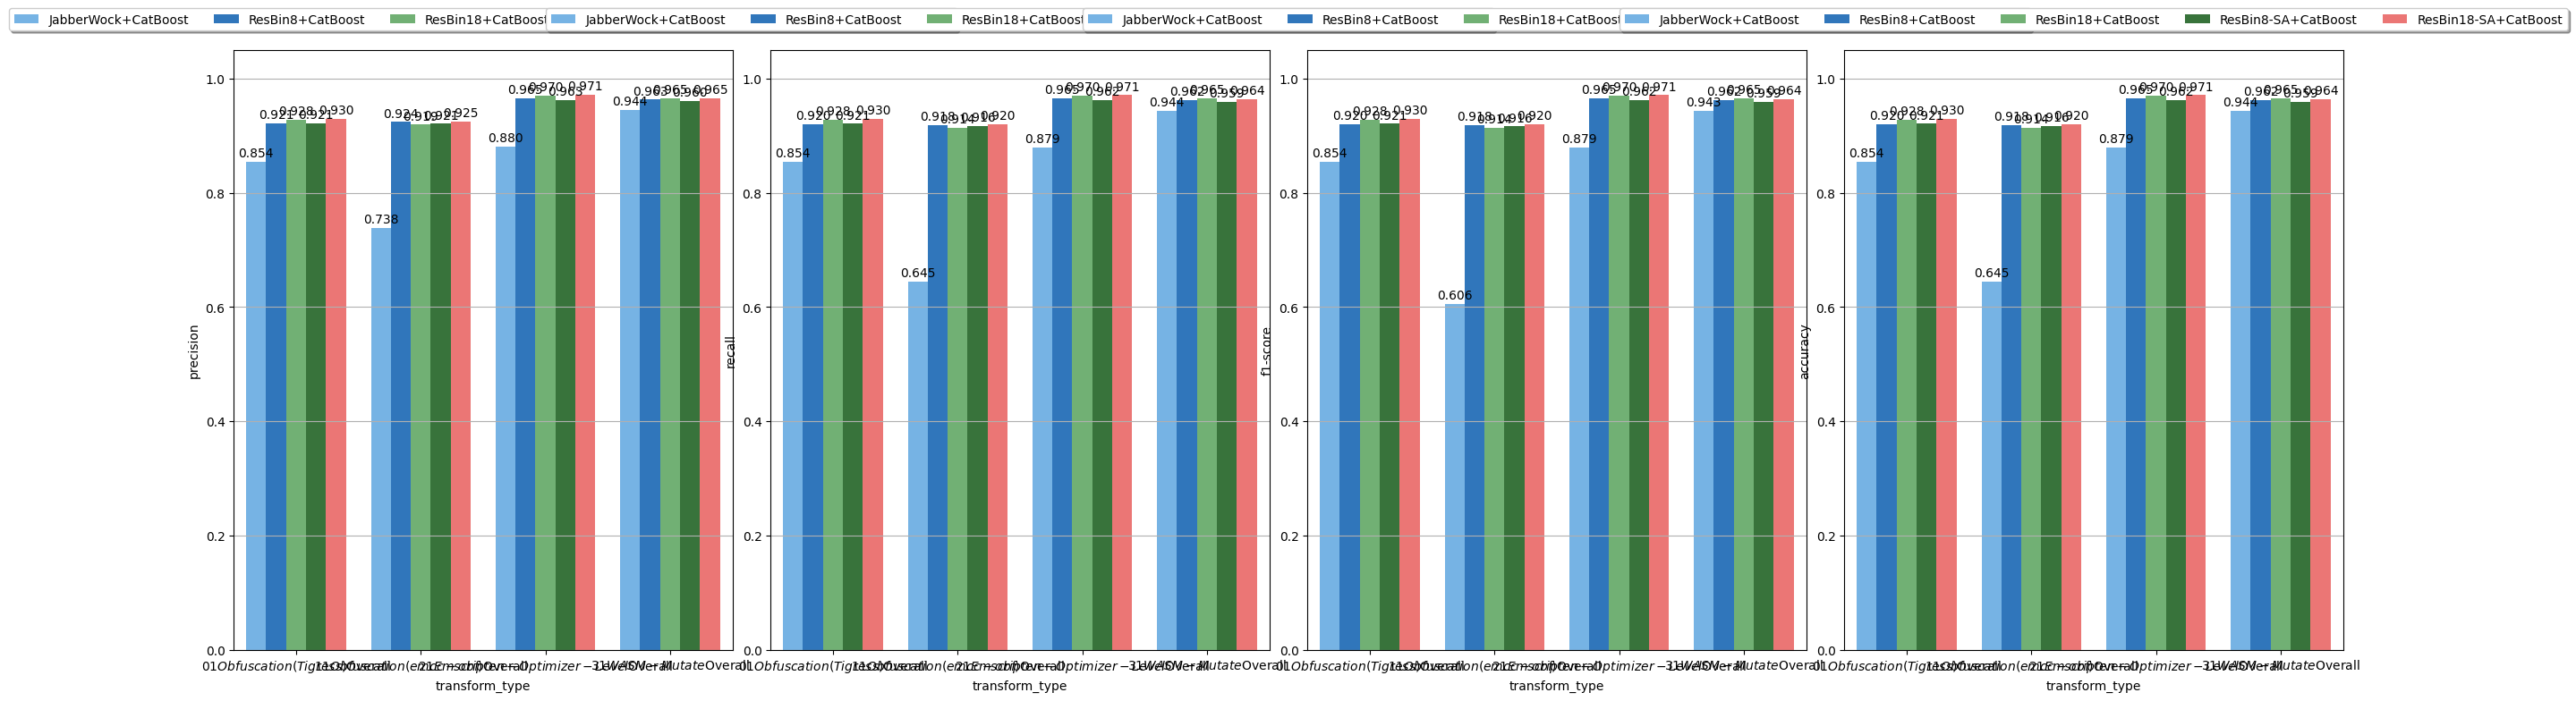

In [50]:
table_groups = {}
table_groups.update({'01$Obfuscation(Tigress)$Overall' : obfuscation_types,})
table_groups.update({'11$Obfuscation(emcc-obf)$Overall' : llvm_obfuscation_types,})
table_groups.update({'21$Emscripten-Optimizer-Level$Overall' : optim_types,})
table_groups.update({'31$WASM-Mutate$Overall' : mutated_types,})
df = drawer_grp(table_groups, new_models, cols=4, show=False)
df_for_paper, _ = table_formatter(df, drop_technique=True)
print(
    df_for_paper.to_latex(
        caption="Similarity detection inference results.", 
        label="tab:rq2_results", 
        multicolumn_format='c',
        float_format="%.4f",
    )
)
df_for_paper

\begin{table}
\caption{Résultats de la détection de la similarité}
\label{tab:rq2_results}
\begin{tabular}{llrrrrrrrrrr}
\toprule
 &  & \multicolumn{2}{c}{JabberWock+CatBoost} & \multicolumn{2}{c}{ResBin8+CatBoost} & \multicolumn{2}{c}{ResBin18+CatBoost} & \multicolumn{2}{c}{ResBin8-SA+CatBoost} & \multicolumn{2}{c}{ResBin18-SA+CatBoost} \\
 &  & f1-score & accuracy & f1-score & accuracy & f1-score & accuracy & f1-score & accuracy & f1-score & accuracy \\
Tool & Technique &  &  &  &  &  &  &  &  &  &  \\
\midrule
\multirow[t]{8}{*}{Obfuscation(Tigress)} & InitOpaque & 0.8950 & 0.8950 & 0.9550 & 0.9550 & 0.9540 & 0.9540 & 0.9490 & 0.9490 & 0.9550 & 0.9550 \\
 & AntiAliasAnalysis & 0.7988 & 0.7990 & 0.9090 & 0.9090 & 0.9230 & 0.9230 & 0.9100 & 0.9100 & 0.9250 & 0.9250 \\
 & EncodeLiterals & 0.8246 & 0.8250 & 0.8260 & 0.8260 & 0.8329 & 0.8330 & 0.8249 & 0.8250 & 0.8430 & 0.8430 \\
 & Flatten & 0.8167 & 0.8170 & 0.9580 & 0.9580 & 0.9650 & 0.9650 & 0.9560 & 0.9560 & 0.9620 & 0.9620 \\
 & An

,,f1-score,accuracy,model_name
Tool,Technique,,,
Obfuscation(Tigress),Overall,0.8541,0.8541,JabberWock+CatBoost
Obfuscation(emcc-obf),Overall,0.6059,0.6446,JabberWock+CatBoost
Emscripten-Optimizer-Level,Overall,0.8793,0.8794,JabberWock+CatBoost
WASM-Mutate,Overall,0.9435,0.9435,JabberWock+CatBoost
Obfuscation(Tigress),Overall,0.9204,0.9204,ResBin8+CatBoost
Obfuscation(emcc-obf),Overall,0.9182,0.9184,ResBin8+CatBoost
Emscripten-Optimizer-Level,Overall,0.9649,0.9649,ResBin8+CatBoost
WASM-Mutate,Overall,0.9622,0.9623,ResBin8+CatBoost
Obfuscation(Tigress),Overall,0.9276,0.9276,ResBin18+CatBoost


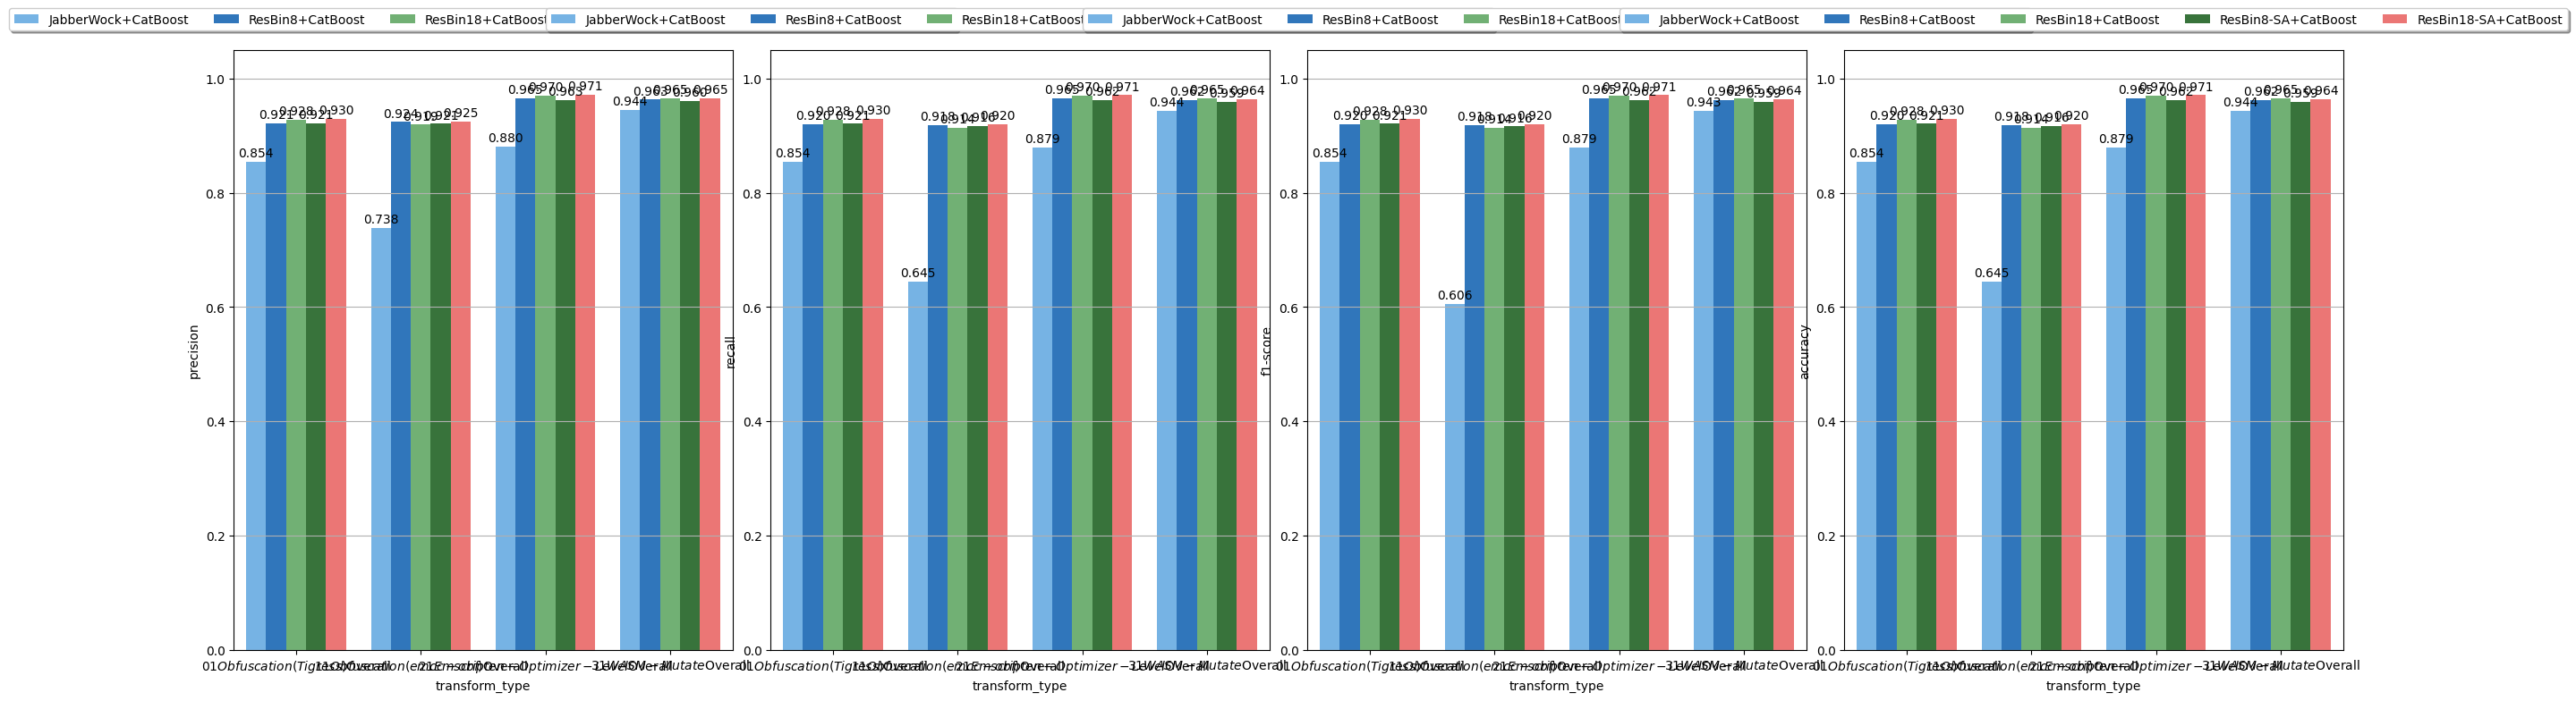

In [53]:
table_groups = {}
table_groups.update({'01$Obfuscation(Tigress)$Overall' : obfuscation_types,})
table_groups.update({'11$Obfuscation(emcc-obf)$Overall' : llvm_obfuscation_types,})
table_groups.update({'21$Emscripten-Optimizer-Level$Overall' : optim_types,})
table_groups.update({'31$WASM-Mutate$Overall' : mutated_types,})

df = drawer_grp(table_groups, new_models, cols=4, show=False)
df_for_rapport, df_for_rapport_barplot = table_formatter(df)
print(
    df_for_paper.to_latex(
        caption="Résultats de la détection de la similarité", 
        label="tab:rq2_results", 
        multicolumn_format='c',
        float_format="%.4f",
    )
)
df_for_rapport_barplot

In [54]:
import matplotlib.pyplot as plt 
import matplotlib.patheffects as pe
plt.style.use('default')
plt.rcParams["axes.grid"] = True

colors = [
  '#fdcc8a','#fc8d59','#ff6361','#d7301f',
  '#ffa600',
  '#00c6ff',]
palette = sns.color_palette(
  colors
)

def plot_all_time(plot_df:pd.DataFrame, ylabel, xlabel, legend, legend_bbox_to_anchor=(0.5, -0.12), ncol_legend=4):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(18,6), facecolor='white')
    ax = axes
    plot_df_cp = plot_df.copy()
    mapper = {
        'ResBin8':0,
        'ResBin8-SA':1,
        'ResBin18':2,
        'ResBin18-SA':3,
        'JabberWock':4,
    }
    g = sns.barplot(
        plot_df_cp.sort_values('model_name', key=lambda l: [mapper[x.split('+')[0]] for x in l]), 
        x='Tool', 
        y=ylabel, 
        hue='model_name', 
        palette=palette, 
        width=0.95,
        edgecolor='black',
        ax=ax,
        saturation=1,
    )
    plt.ylabel(ylabel, fontsize=16)
    plt.xlabel(xlabel, fontsize=16)
    plt.legend(title=legend, fontsize=16)
    g.tick_params(axis='x', labelsize=16)
    g.tick_params(axis='y', labelsize=16)

    _patterns = [ "|" , "O", "\\" , '*' ,  'x', ".", "-", "/", "+" ,]
    patterns = []
    nb_file_sizes = len(plot_df_cp['Tool'].unique())
    for _pat in _patterns:
        patterns += ([_pat]*nb_file_sizes)
        
    for idx, i in enumerate(g.containers):
        g.bar_label(i, fmt='%.4f', rotation=0, padding=14 if idx%2==1 else -1, path_effects=[pe.withStroke(linewidth=3, foreground="white"), ], weight='bold', fontsize=14)
    for idx, i in enumerate(g.patches):
        i.set_hatch(patterns[idx%len(patterns)])

    ax.legend(loc='upper center', bbox_to_anchor=legend_bbox_to_anchor,
          fancybox=True, shadow=True, ncol=ncol_legend, fontsize=16)
    plt.show()


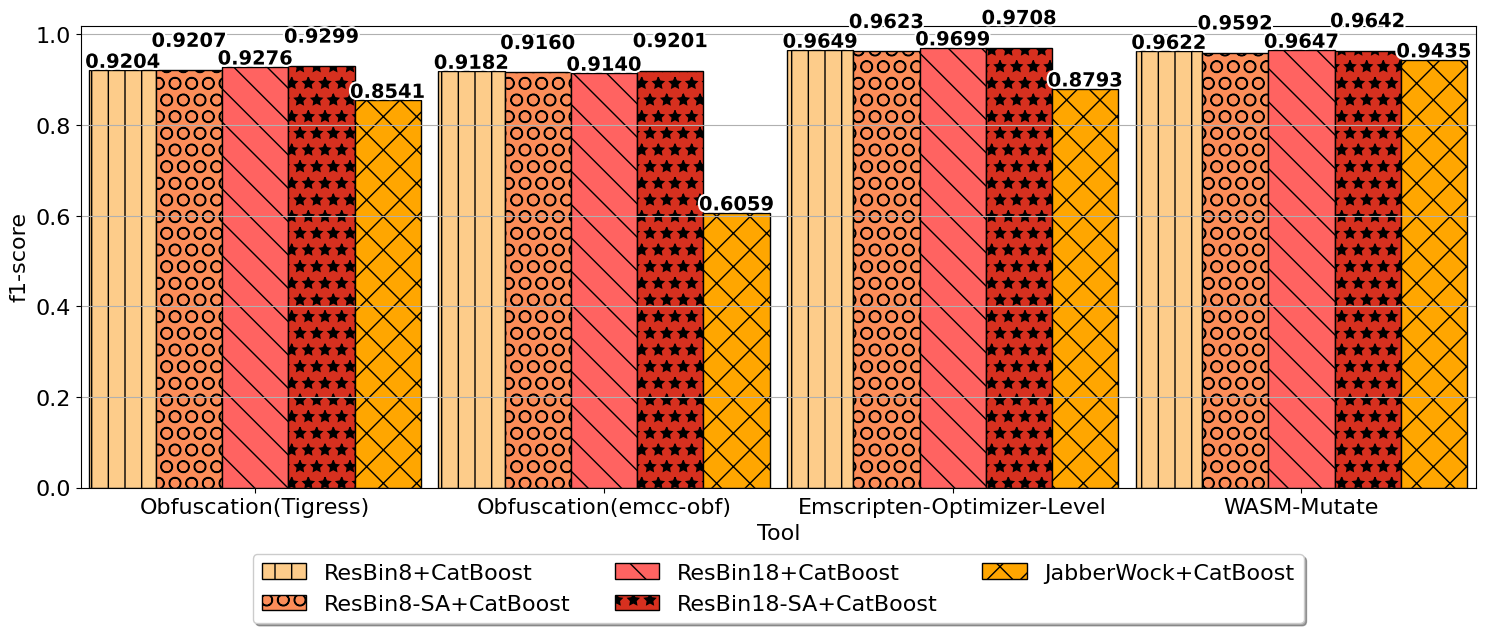

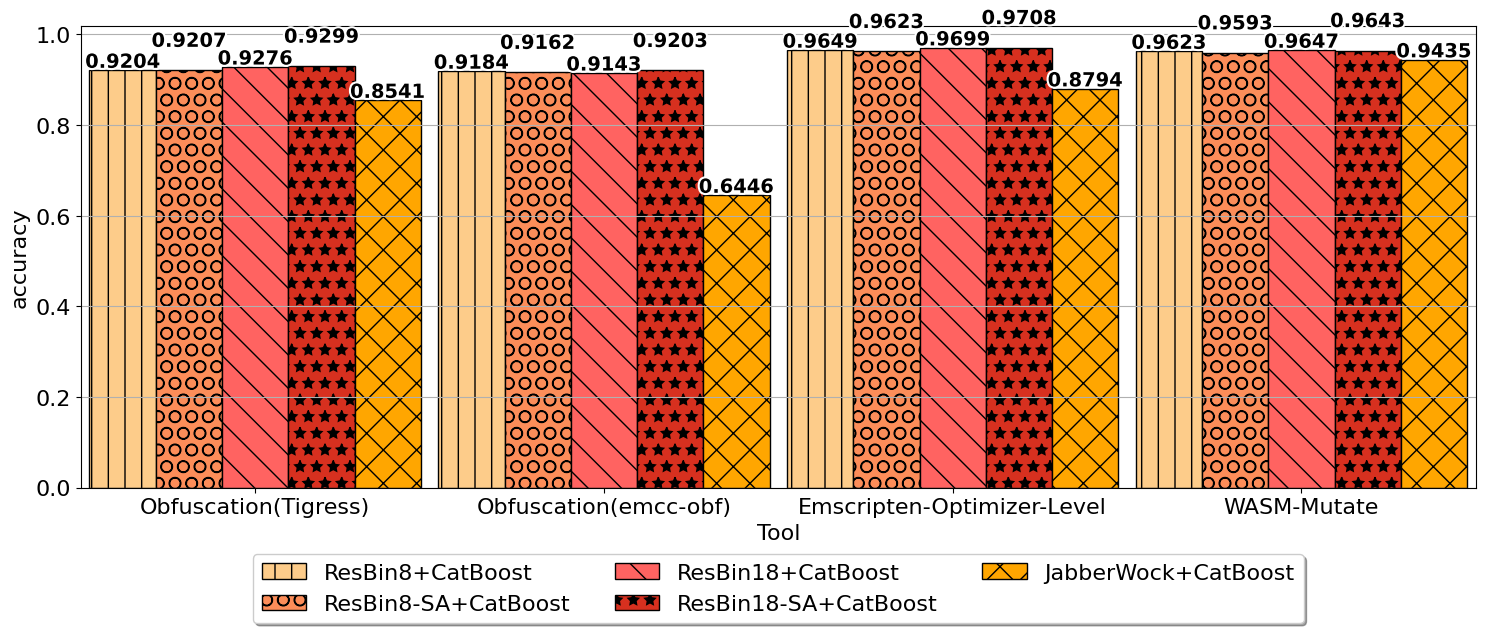

In [55]:
d = df_for_rapport_barplot.reset_index()
plot_all_time(d, ylabel='f1-score', xlabel='Tool', legend='mm', legend_bbox_to_anchor=(0.5, -0.12), ncol_legend=3)
plot_all_time(d, ylabel='accuracy', xlabel='Tool', legend='mm', legend_bbox_to_anchor=(0.5, -0.12), ncol_legend=3)

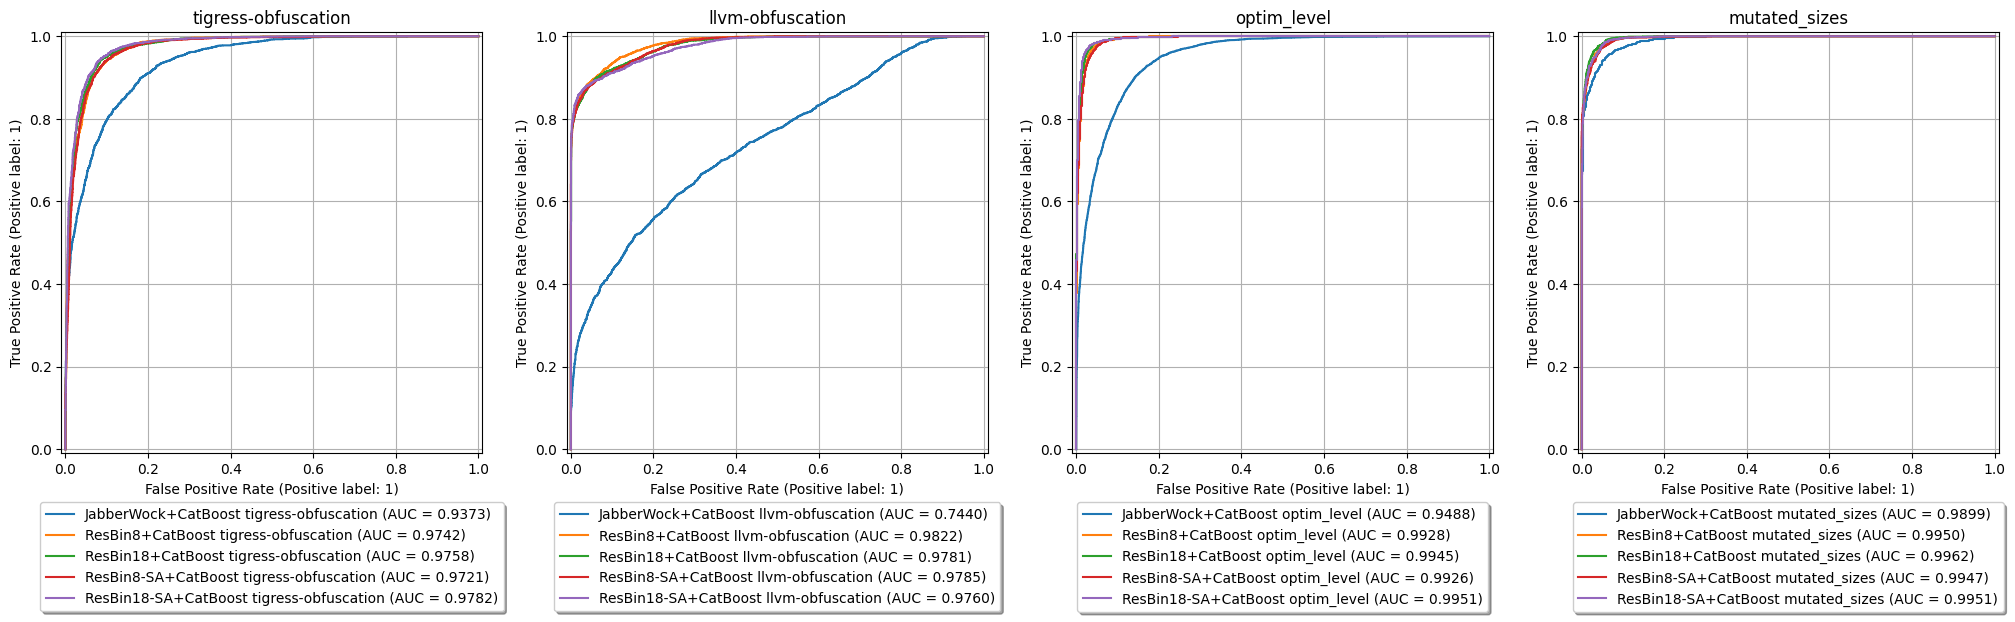

In [57]:
figsize = (25,10)

groups_obfuscation = {
    'tigress-obfuscation' : obfuscation_types,
}
groups_llvm_obfuscation = {
    'llvm-obfuscation' : llvm_obfuscation_types,
}
groups_optim_level = {
    'optim_level' : optim_types,
}
groups_mutated_sizes = {
    'mutated_sizes' : mutated_types,
}

plt.figure(figsize=figsize)

def roc_sklearn_model(sklearn_model, _x_test, _y_test, _x_test_new, _y_test_new, model_name,  col_idx, nb_cols, groups=None, ncol_legend=3):

    X_test = {**_x_test, **_x_test_new}
    y_test = {**_y_test, **_y_test_new}

    from sklearn.metrics import RocCurveDisplay
    sklearn_model.verbose=0
    ax = plt.subplot(1,nb_cols,col_idx)
    integrate_model_name = True

    if groups is None:
        groups = {k:[k] for k in X_test.keys()}
        integrate_model_name = False

    for t, v in groups.items():

        _X_test_v = []
        _y_test_v = []
        for _v in v:
            _X_test_v.extend(X_test[_v])
            _y_test_v.extend(y_test[_v])


        _X_test_v = np.array(_X_test_v)
        _y_test_v = np.array(_y_test_v)
    
        disp = RocCurveDisplay.from_estimator(
            sklearn_model,
            np.array(_X_test_v),
            np.array(_y_test_v),
            ax=ax,
        )
        disp.line_.set_label(
            f"{(model_name if integrate_model_name else '') +' '+ t} (AUC = {disp.roc_auc:.4f})"
        )
        disp.ax_.legend(
            loc='upper center', 
            bbox_to_anchor=(0.5, -0.1), 
            fancybox=True, 
            shadow=True, 
            ncol=ncol_legend
        )
        ax.set_title(t)

for model_name, sklearn_model, train_time, x_train, y_train, x_test, y_test, x_test_new, y_test_new in new_models:
    g_groups = [groups_obfuscation,groups_llvm_obfuscation,groups_optim_level,groups_mutated_sizes]
    for group_id, group in enumerate(g_groups):
        roc_sklearn_model(
            sklearn_model,
            x_test,
            y_test,
            x_test_new,
            y_test_new,
            model_name=model_name,
            groups=group,
            col_idx=group_id+1, nb_cols=len(g_groups),
            ncol_legend=1,
        )
